<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> Binary Variational Semantic Hashing </h1>

<H3 align='center'> Extensión trabajo CIARP </H3>
<hr style="height:2px;border:none"/>

In [1]:
import numpy as np
import keras,gc, os, time, sys
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from scipy.special import expit

from base_networks import *
from utils import check_availability, load_imgs_mask

from utils import get_topK_labels,set_newlabel_list, enmask_data

np.random.seed(20)

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmena/.local/lib/python3.5/site-package

In [1]:
!ls Data/VGG_128

celeba_VGG_avg.npy  cifar10_VGG_avg.npy  mnist_VGG_avg.npy  nuswide_VGG_avg.npy
celeba_VGG.npy	    cifar10_VGG.npy	 mnist_VGG.npy	    nuswide_VGG.npy


## Load Data

### MNIST
---

Imágenes en blanco y negro de 28x28 píxeles, de números del 0 al 9, que dan orígen a las 10 clases del problema.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|60000|10|
|Pruebas|10000|10|

In [2]:
name_dat = "MNIST-raw"

(X_t, aux_t), (X_test, aux_test) = keras.datasets.mnist.load_data()
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
labels_t = np.asarray([labels[value] for value in aux_t])
labels_test = np.asarray([labels[value] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)

X_t = np.concatenate([X_t, X_test], axis=0).reshape(len(labels_t),28*28)
X_t.shape

(70000, 784)

In [49]:
name_dat = "MNIST"

(_, aux_t), (_, aux_test) = keras.datasets.mnist.load_data()
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
labels_t = np.asarray([labels[value] for value in aux_t])
labels_test = np.asarray([labels[value] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)

#X_t = np.load("./Data/VGG_CNN/mnist_VGG_avg.npy")
X_t = np.load("../AUX/VGG_128/mnist_VGG_avg.npy")

X_t.shape

(70000, 512)

In [50]:
##### 1000 imagenes de prueba... 
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100, multi_label=False)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  69000
Cantidad de datos Pruebas:  1000


### CIFAR-10
---
Imágenes RGB pequeñas de  32x32 píxeles, de fotos naturales de distintos objetos.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|50000|10|
|Pruebas|10000|10|

In [139]:
name_dat = "CIFAR-10"

(_, aux_t), (_, aux_test) = keras.datasets.cifar10.load_data()

labels = ["airplane", "automobile","bird", "cat","deer","dog","frog","horse","ship","truck"]
labels_t = np.asarray([labels[value[0]] for value in aux_t])
labels_test = np.asarray([labels[value[0]] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)

#X_t = np.load("./Data/VGG_CNN/cifar10_VGG_avg.npy")
#X_t = np.load("./Data/VGG_64/cifar10_VGG_avg.npy") #mejora

#X_t = np.load("../AUX/VGG_128/cifar10_VGG_avg.npy") #mejora
X_t = np.load("../AUX/VGG_224/cifar10_VGG_avg.npy") #mejora

X_t.shape

(60000, 512)

In [140]:
##### 1000 imagenes de prueba... 
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100, multi_label=False)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  59000
Cantidad de datos Pruebas:  1000


### NUSWIDE
---
* Cantidad de datos totales: 269648
* Datos utlizados (con imagenes disponibles a descargar): 169500
* Datos top-21 clases: 158383

Imágenes de eventos con 81 tópicos asociados, re-dimensionadas a 64x64.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|81|
|Validación|xxx|81|
|Pruebas|xxx|81|

In [104]:
name_dat = "Nus-Wide"

folder = "../Dataset_NUSWIDE/"

mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)

labels = pd.read_csv(folder+'Concepts81.txt',header=None).values.reshape(1,-1)[0]
print("Cantidad de labels: ",len(labels) )

labels_t = [[] for _ in range(269648)]
for concept in labels:
    aux = pd.read_csv(folder+"Groundtruth/AllLabels/Labels_"+concept+".txt",header=None)
    indexs_true = aux.loc[(aux==1).values[:,0]].index
    
    for value in indexs_true:
        labels_t[value].append(concept)
        
labels_t = enmask_data(labels_t, mask_av)
N_total = len(labels_t)
print("Cantidad de objetos: ",N_total )

labels_t[:5]

Cantidad de labels:  81
Cantidad de objetos:  169500


[['person'], ['person'], ['person'], ['person'], ['person']]

#### get top-K labels data

In [105]:
new_labels = get_topK_labels(labels_t, labels, K=21)

labels_t = set_newlabel_list(new_labels, labels_t)
labels = new_labels
# y si quedan datos sin clase?
mask_used_t = np.asarray(list(map(len,labels_t))) != 0

labels_t = enmask_data(labels_t, mask_used_t)
print("Cantidad de objetos: ", len(labels_t) )

category with most data (sky) has = 61066, the top-K category (mountain) has = 4232
Cantidad de objetos:  158383


N_used = 80*1000 #o 150k??
idx_all = np.arange(0, N_total)
mask_used = np.zeros(N_total, dtype=bool)
mask_used[np.random.choice(np.arange(0, N_total), size=N_used, replace=False)] = 1
mask_used

In [106]:
X_t = np.load("../AUX/VGG_224/nuswide_VGG_avg.npy")
X_t.shape

(158383, 512)

In [107]:
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  156283
Cantidad de datos Pruebas:  2100


### CelebA
---
* Cantidad de datos totales: 202599
* Datos en plataforma Kaggle:https://www.kaggle.com/jessicali9530/celeba-dataset 

Imágenes RGB re-dimensionadas a 64x64 píxeles, de fotos naturales de rostros de celebridades. Una muestra es utilizada

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|40|
|Validación|xxx|40|
|Pruebas|xxx|40|

mask_av = check_availability(folder+"small_images/", labels_t)
np.savetxt("./Data/+"name_dat+"_mask_avail.txt", mask_av, fmt="%1i")

In [92]:
name_dat = "CelebA"
mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)

folder = "../CelebA/"

part = pd.read_csv(folder+"list_eval_partition.csv")
mask_train = (part["partition"].values == 0)[mask_av]
mask_val = (part["partition"].values == 1)[mask_av]
mask_test = (part["partition"].values == 2)[mask_av]

df_atrr = pd.read_csv(folder+"list_attr_celeba.csv")[mask_av]
img_names = df_atrr["image_id"].values
labels = list(df_atrr.columns[1:])
print("Cantidad de labels: ",len(labels) )

N_total = len(df_atrr)
print("Cantidad de objetos: ",N_total )
aux = (df_atrr == 1).values
labels_t = np.asarray([list(df_atrr.columns[aux[value]]) for value in range(N_total)])
labels[:5]

Cantidad de labels:  40
Cantidad de objetos:  202599


['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald']

In [93]:
X_t = np.load("./Data/VGG_128/celeba_VGG_avg.npy")
X_t.shape

(202599, 512)

In [94]:
from utils import sample_test_mask
mask_train = sample_test_mask(labels_t, N=100)

## creat test como dicen...
X_test = X_t[~mask_train]
X_t = X_t[mask_train]
labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  198599
Cantidad de datos Pruebas:  4000


### Validation creation

Pre-process: División por 255

In [4]:
X_t = X_t.astype("float32")/255
X_test = X_test.astype("float32")/255
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [141]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_t)

X_t = std.transform(X_t)
X_test = std.transform(X_test)
X_t

array([[ 3.3634403 ,  1.6491311 ,  1.7156701 , ..., -0.4954083 ,
        -0.10966182,  0.33191326],
       [-0.18719149, -0.45493087, -0.5005233 , ..., -0.4954083 ,
         1.1623096 , -0.45836106],
       [-0.45166254, -0.45493087, -0.5005233 , ...,  0.31817105,
        -0.5580158 , -0.24086328],
       ...,
       [-0.26130196, -0.4091533 ,  1.4187546 , ...,  0.26868737,
         0.1864351 ,  0.7117243 ],
       [-0.45166254,  0.0612663 , -0.5005233 , ..., -0.38322145,
         0.4404042 , -0.2049015 ],
       [-0.45166254, -0.45493087, -0.5005233 , ...,  2.9680657 ,
        -0.6262276 ,  0.45511922]], dtype=float32)

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_val, labels_train, labels_val  = train_test_split(X_t, labels_t, random_state=20,test_size=len(X_test))

print("Cantidad de datos Entrenamiento: ",len(X_train))
print("Cantidad de datos Validación: ",len(X_val))
print("Cantidad de datos Pruebas: ",len(X_test))
del X_t, labels_t
gc.collect()

Cantidad de datos Entrenamiento:  58000
Cantidad de datos Validación:  1000
Cantidad de datos Pruebas:  1000


10

In [143]:
X_train_input = X_train
X_val_input = X_val
X_test_input = X_test

### Model Architecture
---
CNN
https://github.com/rtflynn/Cifar-Autoencoder

In [54]:
raw = False

In [55]:
def REC_loss(x_true, x_pred):
    if raw:
        return K.mean( K.binary_crossentropy(x_true, x_pred), axis=-1)
    else:
        return K.mean( (x_true- x_pred)**2 ,axis=-1)  #it should be VGG

In [56]:
def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True, beta=0, summ=True):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    if raw:
        generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN, out_type='sigmoid')
    else:
        generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN, out_type='linear')    
    if summ:
        print("pre-encoder network:")
        pre_encoder.summary()
        print("generator network:")
        generator.summary()
    ## Encoder
    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_var = Dense(Nb,activation='linear',name = 'z-log_var')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5*z_log_var) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_var])
    output = generator(z_sampled)
    
    Recon_loss = REC_loss
    kl_loss = KL_loss(z_mean,z_log_var)
    def VAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt, loss=VAE_loss, metrics = [Recon_loss,kl_loss])
    
    return traditional_vae, encoder,generator

In [57]:
import keras.backend as K
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)

def binary_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True,beta=0., summ=True):
    tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3
    
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    if raw:
        generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN, out_type='sigmoid')
    else:
        generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN, out_type='linear')
    if summ:
        print("pre-encoder network:")
        pre_encoder.summary()
        print("generator network:")
        generator.summary()

    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(B_j/1-B_j)
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recupera probabilidad
    #dist = Dense(Nb, activation='sigmoid')(hidden) #p(b) #otra forma de modelarlo
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)
        
    Recon_loss = REC_loss
    kl_loss = BKL_loss(logits_b)
    def BVAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=BVAE_loss, metrics = [Recon_loss,kl_loss])
    return binary_vae, encoder,generator


### Train details
---

* 30* epochs* 
* *batch size* de 200
* optimizador Adam
* Inicializador de Glorot (para los pesos)

In [58]:
from utils import  compare_hist_train, add_hist_plot

batch_size = 100*2 #ya que son datasets mas grandes
epochs = 30 

In [36]:
from utils import find_beta

def create_model_T(beta_V):
    return traditional_VAE(X_train_input.shape[1],Nb=32,units=500,layers_e=2,layers_d=0
                                                                  ,beta=beta_V, summ=False)
def create_model_B(beta_V):
    return binary_VAE(X_train_input.shape[1],Nb=32,units=500,layers_e=2,layers_d=0
                                                                  ,beta=beta_V, summ=False)

In [37]:
beta_T = find_beta(create_model_T, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=False, BS=batch_size)
beta_B = find_beta(create_model_B, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=True, BS=batch_size)

***************************************
*********** SUMMARY RESULTS ***********
***************************************


,beta,score
0,1.000000,0.4453
1,0.500000,0.4477
2,0.250000,0.4980
3,0.125000,0.6048
4,0.062500,0.6385
5,0.031250,0.6847
6,0.015625,0.7094
7,0.007812,0.7439
8,0.003906,0.7614
9,0.001953,0.7635


Best value is 0.7786 with beta 0.000008
Worst value is 0.4453 with beta 1.000000
***************************************
***************************************
*********** SUMMARY RESULTS ***********
***************************************


,beta,score
0,1.000000,0.2422
1,0.500000,0.3660
2,0.250000,0.4665
3,0.125000,0.5928
4,0.062500,0.4887
5,0.031250,0.6490
6,0.015625,0.7261
7,0.007812,0.7920
8,0.003906,0.8151
9,0.001953,0.8279


Best value is 0.8309 with beta 0.000015
Worst value is 0.2422 with beta 1.000000
***************************************


In [14]:
## para mnist raw
beta_T = 0.000015
beta_B = 0.000122

In [59]:
### PARA MNIST-vGG!!
beta_T = 0.000008
beta_B = 0.000015

In [144]:
### PARA CIFAR VGG128!!
beta_T = 0.000122
beta_B = 0.000122

In [84]:
### PARA CIFAR VGG224!!
beta_T = 0.000008
beta_B = 0.003906

In [111]:
### PARA NUSWIDE!!
beta_T = 0.000008
beta_B = 0.001953

In [ ]:
### falta celebA

In [112]:
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta=beta_T)

hist1 = traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val))

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

In [113]:
binary_vae,encoder_Bvae,generator_Bvae= binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta=beta_B)

hist2 = binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val) )
                       #,callbacks=[Tau_Call(tau)] )

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

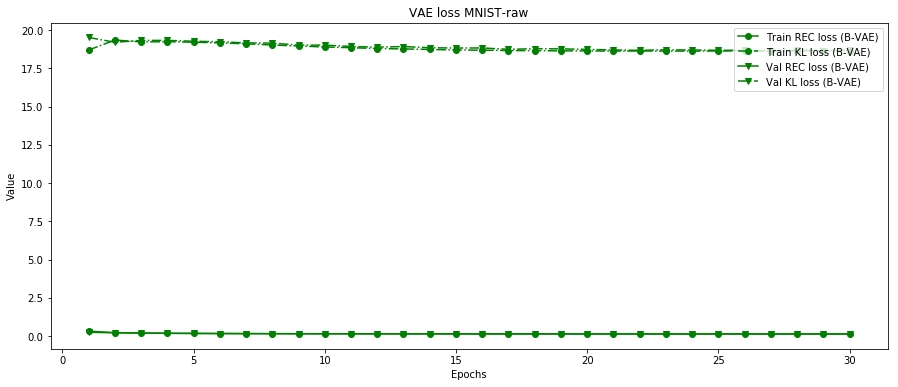

In [15]:
plt.figure(figsize=(15,6))
add_hist_plot(hist2, c='g', model_n = "B-VAE")
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc="upper right", fancybox= True)
plt.title("VAE loss "+name_dat)
plt.show()

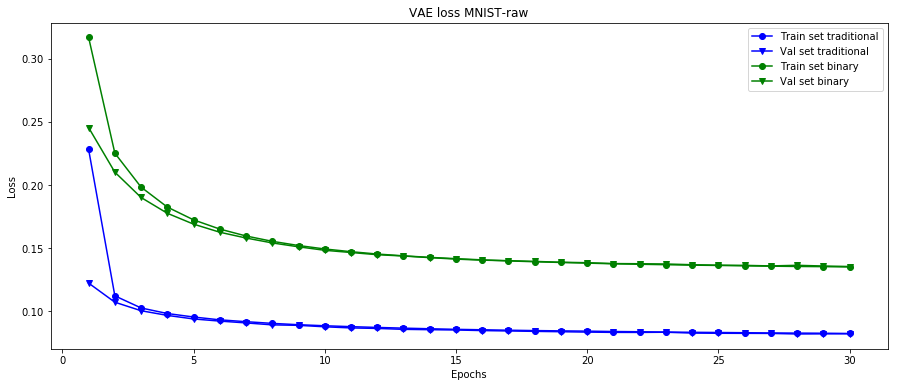

In [16]:
compare_hist_train(hist1,hist2, name_dat)

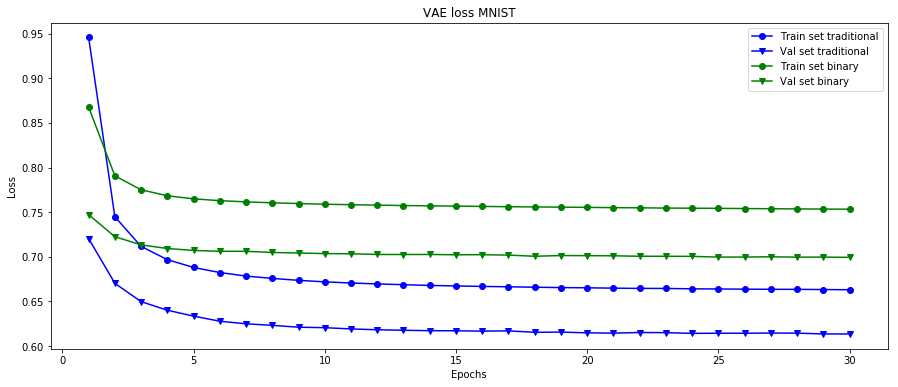

In [62]:
compare_hist_train(hist1,hist2, name_dat) #--64 dim

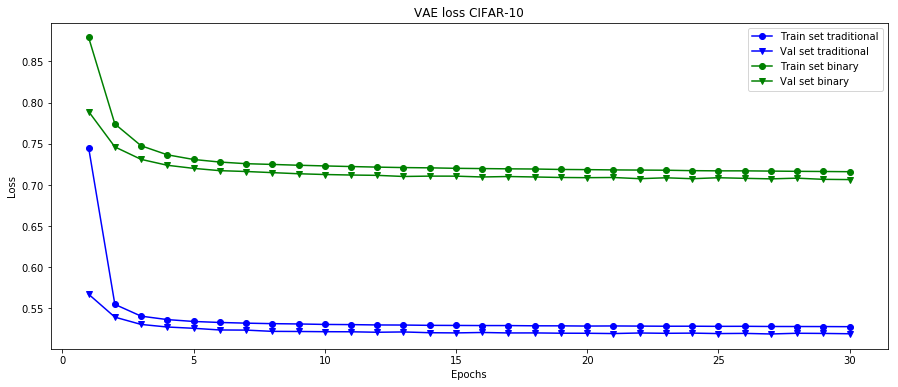

In [87]:
compare_hist_train(hist1,hist2, name_dat) #--64 dim

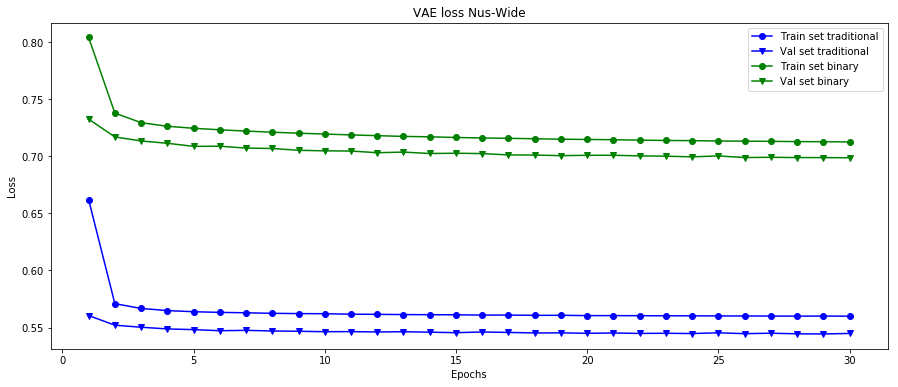

In [114]:
compare_hist_train(hist1,hist2, name_dat) #--64 dim

### Another intrinsic measure: *Classification*


In [17]:
#function to define and train model
from sklearn.metrics import jaccard_score
from utils import define_fit, MedianHashing, visualize_probas, visualize_mean, calculate_hash, visualize_probas_byB

results = []
results_S = []
results_B = []
results_O_B = [] #original testing on tresholded

In [115]:
#codify input data (binarize -- or aprox)
X_train_logits = encoder_Bvae.predict(X_train_input)
X_val_logits = encoder_Bvae.predict(X_test_input)

#probabilities
X_train_Bcode = expit(X_train_logits)
X_val_Bcode = expit(X_val_logits)

#Z-mean
X_train_Tcode = encoder_Tvae.predict(X_train_input)
X_val_Tcode = encoder_Tvae.predict(X_test_input)

##codify labels
labels_aux = np.asarray(labels)
def codify_labels(inputs):
    inputs = np.asarray(inputs)
    matrix_labels = np.zeros((inputs.shape[0],labels_aux.shape[0]))
    for i,aux_labels in enumerate(inputs):
        if type(aux_labels) == list or type(aux_labels) == np.ndarray :
            for aux_label in aux_labels:
                idx = np.where(aux_label==labels_aux)[0]
                matrix_labels[i,idx] = 1 #various-multiple
        else:
            idx = np.where(aux_labels==labels_aux)[0]
            matrix_labels[i,idx] = 1 #only one
    return matrix_labels

C_train = codify_labels(labels_train)
#C_val = codify_labels(labels_val)
C_val = codify_labels(labels_test)
C_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

MNIST-raw


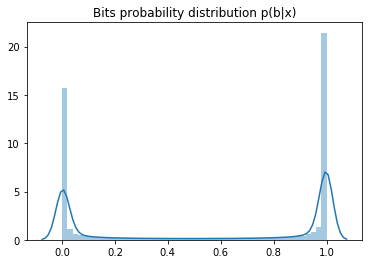

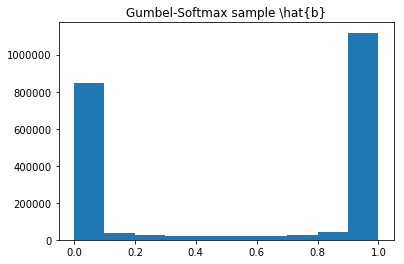

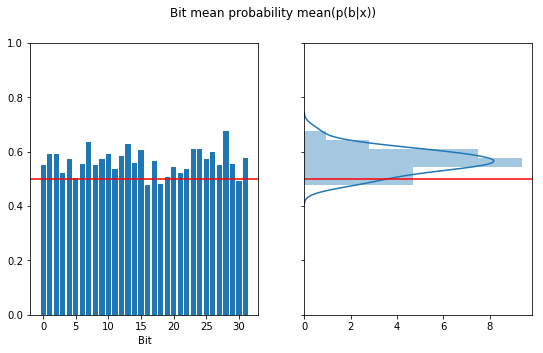

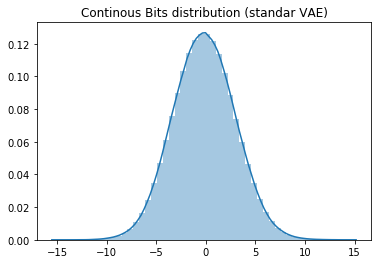

In [22]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

visualize_mean(X_train_Tcode)

MNIST


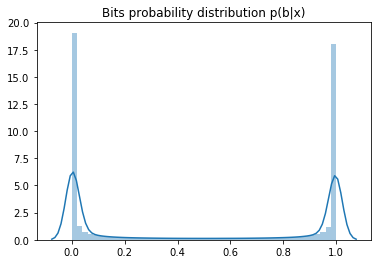

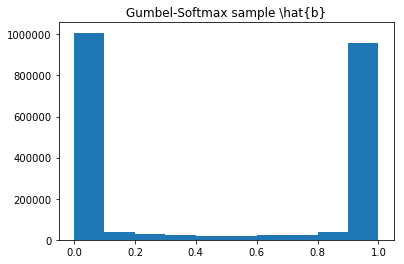

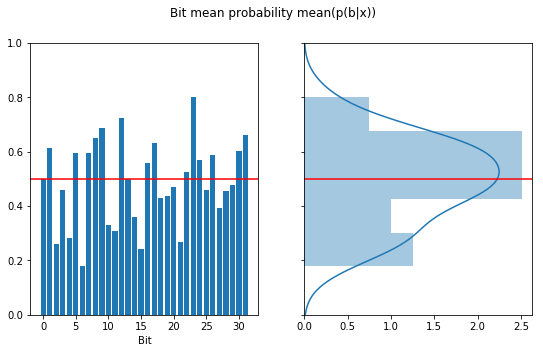

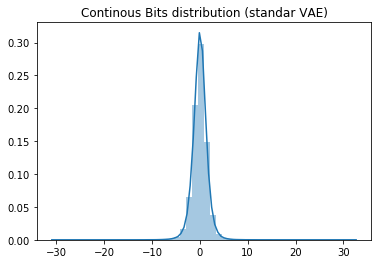

In [64]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

visualize_mean(X_train_Tcode)

CIFAR-10


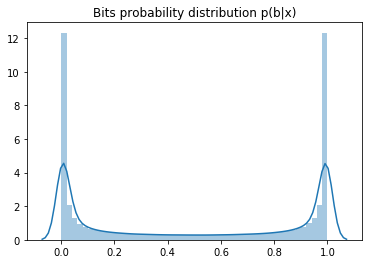

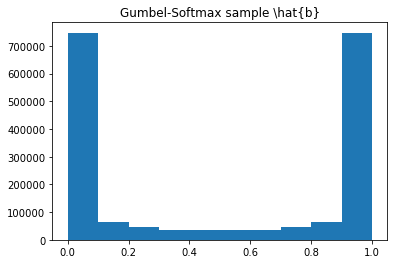

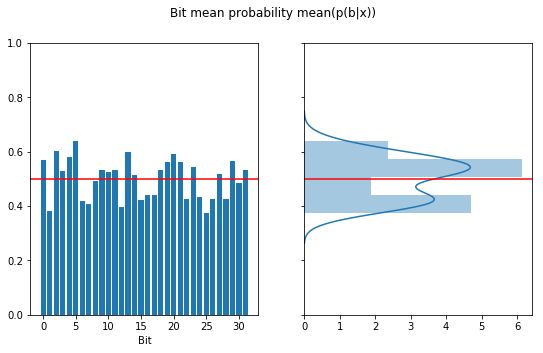

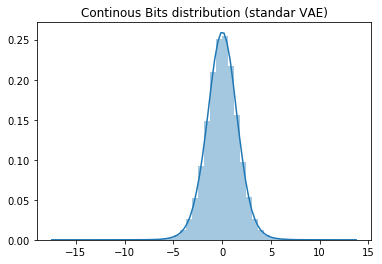

In [89]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

visualize_mean(X_train_Tcode)

Nus-Wide


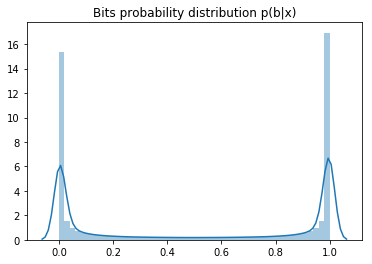

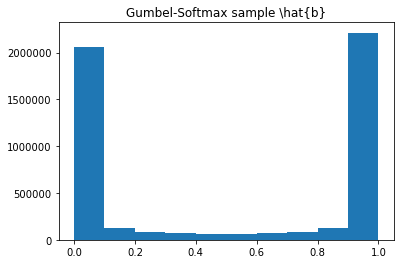

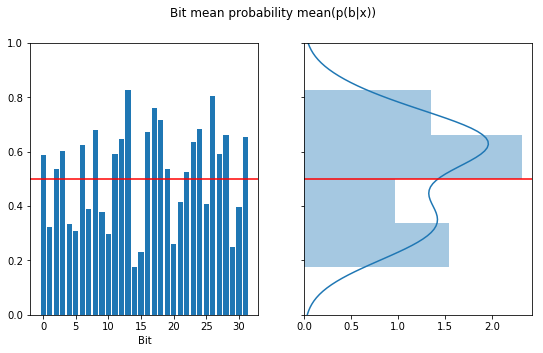

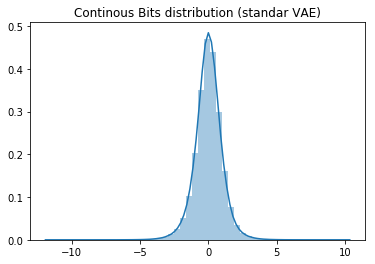

In [116]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

visualize_mean(X_train_Tcode)

In [117]:
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

model1_O = define_fit(multi_label,X_train_Bcode,C_train)
model2_O = define_fit(multi_label,X_train_Tcode,C_train)

if not multi_label:
    aux.append(model2_O.evaluate(X_train_Tcode,C_train,verbose=0)[1])
    aux.append(model2_O.evaluate(X_val_Tcode,C_val,verbose=0)[1])

    aux.append(model1_O.evaluate(X_train_Bcode,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2_O.predict(X_train_Tcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2_O.predict(X_val_Tcode)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode)>=0.5)*1, average='micro'))
    
results.append(aux)
print("Done")

Done


In [118]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))


Accuracy on dataset:  mnist-raw
Traditional VAE (train-val): 0.997132 - 0.982000
Binary VAE (train-val): 0.969206 - 0.969000

Accuracy on dataset:  mnist
Traditional VAE (train-val): 0.980500 - 0.956000
Binary VAE (train-val): 0.942368 - 0.930000

Accuracy on dataset:  cifar-10
Traditional VAE (train-val): 0.880069 - 0.821000
Binary VAE (train-val): 0.805828 - 0.768000

Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.540700 - 0.495073
Binary VAE (train-val): 0.477749 - 0.421275


In [119]:
## binary // treshold it

X_train_Tcode_B = calculate_hash(X_train_Tcode, from_probas=False)
X_val_Tcode_B = calculate_hash(X_val_Tcode, from_probas=False)

X_train_Bcode_B = calculate_hash(X_train_Bcode, from_probas=True, from_logits=False)
X_val_Bcode_B = calculate_hash(X_val_Bcode, from_probas=True, from_logits=False)

X_train_Tcode_B

array([[1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 1, 1]], dtype=int32)

In [120]:
### trained models over encoder representation testing on tresholded representation (see how decrease)
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

if not multi_label:
    aux.append(model2_O.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2_O.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1_O.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2_O.predict(X_train_Tcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2_O.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_O_B.append(aux)
print("Done")

Done


In [121]:
print("Classification on Binary (thresholded) representation")
for valores in results_O_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary (thresholded) representation

Accuracy on dataset:  mnist-raw
Traditional VAE (train-val): 0.337574 - 0.352000
Binary VAE (train-val): 0.941426 - 0.935000

Accuracy on dataset:  mnist
Traditional VAE (train-val): 0.435868 - 0.445000
Binary VAE (train-val): 0.915544 - 0.895000

Accuracy on dataset:  cifar-10
Traditional VAE (train-val): 0.419379 - 0.418000
Binary VAE (train-val): 0.729190 - 0.698000

Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.336808 - 0.312622
Binary VAE (train-val): 0.433175 - 0.378767


In [122]:
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

model1 = define_fit(multi_label,X_train_Bcode_B,C_train)
model2 = define_fit(multi_label,X_train_Tcode_B,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode_B)>=0.5)*1, average='micro')) 
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_B.append(aux)
print("Done")

Done


In [123]:
print("Classification on Binary representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary representation

Accuracy on dataset:  mnist-raw
Traditional VAE (train-val): 0.902912 - 0.894000
Binary VAE (train-val): 0.945059 - 0.920000

Accuracy on dataset:  mnist
Traditional VAE (train-val): 0.907647 - 0.881000
Binary VAE (train-val): 0.922147 - 0.894000

Accuracy on dataset:  cifar-10
Traditional VAE (train-val): 0.735362 - 0.707000
Binary VAE (train-val): 0.749207 - 0.717000

Accuracy on dataset:  nus-wide
Traditional VAE (train-val): 0.447790 - 0.392463
Binary VAE (train-val): 0.451749 - 0.393618




### Results
---

In [26]:
from utils import MedianHashing, get_similar, measure_metrics, calculate_hash
from utils import MAP_atk, M_P_atk, AP_atk

### Experimentación
---
A continación se realizan las experimentaciones correspondientes para encontrar la mejor arquitectura y mejor configuración del modelo propuesto en base a las métricas *precision* y *recall* del conjunto de validación en el **top 100** de elementos recuperados.

In [27]:
def evaluate_hashingB(encoder,train,val,labels_train,labels_val,traditional=True,tipo="topK",K=100):
    encode_train = encoder.predict(train)
    encode_val = encoder.predict(val)
    
    train_hash = calculate_hash(encode_train, from_probas=~traditional )
    val_hash = calculate_hash(encode_val, from_probas=~traditional)

    val_similares_train =  get_similar(val_hash, train_hash, tipo=tipo,K=K) 

    return measure_metrics(labels,val_similares_train,labels_query=labels_val,labels_source=labels_train)


### Experimentando variando el #Bits

In [28]:
traditional_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},
                   "celeba":{"p":[],"r":[]},'nus-wide':{"p":[],"r":[]},
                  "mnist-raw":{"p":[],"r":[]}}
binary_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},
              "celeba":{"p":[],"r":[]},'nus-wide':{"p":[],"r":[]},
               "mnist-raw":{"p":[],"r":[]}}

In [124]:
Nbits = np.asarray([4,8,16,32,64])
dataset = name_dat.lower()

for Nbit in Nbits:
    traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0,beta=beta_T)
    hist1 = traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size, verbose=0
                           ,validation_data=(X_val_input,X_val))
    p_t,r_t = evaluate_hashingB(encoder_Tvae,X_train_input,X_val_input,labels_train,labels_val,traditional=True,tipo="topK")
    traditional_dat[dataset]["p"].append(p_t) 
    traditional_dat[dataset]["r"].append(r_t) 
    del traditional_vae, encoder_Tvae, generator_Tvae
    keras.backend.clear_session()
    gc.collect()
    
    binary_vae,encoder_Bvae,generator_Bvae= binary_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0,beta=beta_B)
    hist2 = binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size, verbose=0
                           ,validation_data=(X_val_input,X_val) )
    p_b,r_b = evaluate_hashingB(encoder_Bvae,X_train_input,X_val_input,labels_train,labels_val,traditional=False,tipo="topK")
    binary_dat[dataset]["p"].append(p_b) 
    binary_dat[dataset]["r"].append(r_b) 
    del binary_vae, encoder_Bvae, generator_Bvae
    keras.backend.clear_session()
    gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)               256500    
_________________________________________________________________
batch_normalization_5 (Batch (None, 500)               2000      
_________________________________________________________________
dense_16 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_6 (Batch (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

In [125]:
print("Resultados de Precision en validación")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["MNIST-R"] = traditional_dat["mnist-raw"]["p"]
t["MNIST"] = traditional_dat["mnist"]["p"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["p"]
t["Nus-Wide"] = traditional_dat["nus-wide"]["p"]
print("\n*** VAE Traditional***")
print(t)

t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["MNIST-R"] = binary_dat["mnist-raw"]["p"]
t["MNIST"] = binary_dat["mnist"]["p"]
t["CIFAR-10"] = binary_dat["cifar-10"]["p"]
t["Nus-Wide"] = binary_dat["nus-wide"]["p"]
print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["MNIST-R"] = traditional_dat["mnist-raw"]["r"]
t["MNIST"] = traditional_dat["mnist"]["r"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["r"]
t["Nus-Wide"] = traditional_dat["nus-wide"]["r"]
print("\n*** VAE Traditional***")
print(t)

t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["MNIST-R"] = binary_dat["mnist-raw"]["r"]
t["MNIST"] = binary_dat["mnist"]["r"]
t["CIFAR-10"] = binary_dat["cifar-10"]["r"]
t["Nus-Wide"] = binary_dat["nus-wide"]["r"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
   N bits  MNIST-R    MNIST  CIFAR-10  Nus-Wide
0       4  0.20942  0.30971   0.27799  0.579981
1       8  0.48137  0.53648   0.39359  0.657829
2      16  0.61374  0.66433   0.44692  0.699519
3      32  0.72301  0.76987   0.48751  0.728110
4      64  0.78120  0.81210   0.53129  0.752552

*** VAE Binary***
   N bits  MNIST-R    MNIST  CIFAR-10  Nus-Wide
0       4  0.38815  0.38080   0.29913  0.603005
1       8  0.57952  0.59213   0.40980  0.658038
2      16  0.75372  0.74782   0.48297  0.705157
3      32  0.81850  0.82652   0.53529  0.738638
4      64  0.85937  0.85364   0.56353  0.752414

Resultados de Recall en validación

*** VAE Traditional***
   N bits   MNIST-R     MNIST  CIFAR-10  Nus-Wide
0       4  0.003039  0.004505  0.004794  0.001237
1       8  0.006974  0.007833  0.006787  0.001492
2      16  0.008945  0.009710  0.007707  0.001643
3      32  0.010575  0.011280  0.008406  0.001715
4      64  0.011436  0.011914  0.

## *Best models facing test set*
Luego de la selección de la mejor configuración de los modelos se evalua de diferentes formas sobre el conjunto de pruebas de los distintos *datasets*, los cambios realizados son:
* Se entrenan sobre todos los datos disponibles (*train+val*)
* Se aumentó el número de *epochs* a 50.

El mejor modelo:
* Simétrica para *Binary VAE* y Base para *Traditional VAE*
* 32 Bits en la codificación (número de variables latentes)
* Representación sobre las top 10 mil *tokens* más frecuentes y *Term Frequency*

In [30]:
from utils import calculate_hash
def evaluate_hashing_DE(train_hash,test_hash,labels_trainn,labels_testt,tipo="topK",eval_tipo='PRatk',K=100):
    """
        Evaluate Hashing correclty: Query and retrieve on a different set
    """
    test_similares_train =  get_similar(test_hash,train_hash,tipo=tipo,K=K)
    if eval_tipo=="MAP":
        return MAP_atk(test_similares_train,labels_query=labels_testt, labels_source=labels_trainn, K=0) #all ranking
    elif eval_tipo == "PRatk":
        return measure_metrics(labels,test_similares_train,labels_testt,labels_source=labels_trainn)
    elif eval_tipo == "Patk":
        return M_P_atk(test_similares_train, labels_query=labels_testt, labels_source=labels_trainn, K=K)

def hash_data(model, x_train, x_test, binary=True):
    encode_train = model.predict(x_train)
    encode_test = model.predict(x_test)
    
    train_hash = calculate_hash(encode_train, from_probas=binary )
    test_hash = calculate_hash(encode_test, from_probas = binary)
    return train_hash, test_hash

#to save results
results_dat = {"mnist":{},"mnist-raw":{},"cifar-10":{},"celeba":{}, "nus-wide":{}} 


BITS_S = 32

In [145]:
X_total = np.concatenate((X_train,X_val),axis=0)
X_total_input = X_total
labels_total = np.concatenate((labels_train,labels_val),axis=0)
del X_train, X_train_input, X_val, X_val_input, labels_train,labels_val
gc.collect()

0

In [146]:
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_total.shape[1],Nb=BITS_S,units=500,layers_e=2,layers_d=0,beta=beta_T)
traditional_vae.fit(X_total_input, X_total, epochs=epochs, batch_size=batch_size,verbose=0)
#save model
#encoder_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
###generator_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_D_defaultCNN.h5") #it is not used


binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_total.shape[1],Nb=BITS_S,units=500,layers_e=2,layers_d=0,beta=beta_B)
binary_vae.fit(X_total_input, X_total, epochs=epochs, batch_size=batch_size,verbose=0)
#save model
#encoder_Bvae.save("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
#generator_Bvae.save_weights("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN_w.h5")

#keras.backend.clear_session()
#gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

##load model
encoder_Tvae = keras.models.load_model("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
encoder_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
#generator_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN.h5")
encoder_Bvae.summary()

In [147]:
total_hash_VAE, test_hash_VAE = hash_data(encoder_Tvae,X_total_input,X_test_input, binary=False)
total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_total_input,X_test_input)

del X_total_input, X_test_input, X_test, X_total
gc.collect()

keras.backend.clear_session()
gc.collect()

0

In [129]:
dataset = name_dat.lower()

p_t,r_t = evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,tipo="topK")
results_dat[dataset]["p"] = [p_t]
results_dat[dataset]["r"] = [r_t]
p5k_t = evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="Patk",K=5000)
results_dat[dataset]["p5k"] = [p5k_t]

p_b,r_b = evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,tipo="topK")
results_dat[dataset]["p"].append(p_b)
results_dat[dataset]["r"].append(r_b)
p5k_b = evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="Patk",K=5000)
results_dat[dataset]["p5k"].append(p5k_b)

print("Realizado.")

Realizado.


In [130]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = pd.DataFrame() #Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST-R"] = results_dat["mnist-raw"]["p"]
t["MNIST"] = results_dat["mnist"]["p"]
t["CIFAR-10"] = results_dat["cifar-10"]["p"]
#t["CelebA"] = results_dat["celeba"]["p"]
t["Nus-Wide"] = results_dat["nus-wide"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = pd.DataFrame() #Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST-R"] = results_dat["mnist-raw"]["r"]
t["MNIST"] = results_dat["mnist"]["r"]
t["CIFAR-10"] = results_dat["cifar-10"]["r"]
#t["CelebA"] = results_dat["celeba"]["r"]
t["Nus-Wide"] = results_dat["nus-wide"]["r"]
print(t)

print("\n\nResultados de Precision en pruebas (top-5k)")
t = pd.DataFrame() #Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST-R"] = results_dat["mnist-raw"]["p5k"]
t["MNIST"] = results_dat["mnist"]["p5k"]
t["CIFAR-10"] = results_dat["cifar-10"]["p5k"]
#t["CelebA"] = results_dat["celeba"]["p5k"]
t["Nus-Wide"] = results_dat["nus-wide"]["p5k"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
        Modelo  MNIST-R    MNIST  CIFAR-10  Nus-Wide
0  Tradicional  0.72420  0.77669   0.49559  0.761557
1      Binario  0.82706  0.82045   0.53305  0.766700


Resultados de Recall en pruebas
        Modelo   MNIST-R     MNIST  CIFAR-10  Nus-Wide
0  Tradicional  0.010465  0.011245  0.008400  0.001522
1      Binario  0.011972  0.011893  0.009035  0.001541


Resultados de Precision en pruebas (top-5k)
        Modelo   MNIST-R     MNIST  CIFAR-10  Nus-Wide
0  Tradicional  0.344055  0.476328  0.293654  0.670298
1      Binario  0.451737  0.559916  0.311723  0.681324


In [35]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on MNIST-raw dataset
Traditional VAE =  0.28624200795719834
Binary VAE =  0.39133812588027717


In [77]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on MNIST dataset
Traditional VAE =  0.41840910705719286
Binary VAE =  0.5038414566144952


In [102]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on CIFAR-10 dataset
Traditional VAE =  0.2547489501287524
Binary VAE =  0.2740976506100716


In [132]:
print("MAP on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on Nus-Wide dataset
Traditional VAE =  0.5231913090275315
Binary VAE =  0.5410494456407475


In [131]:
print("MAP@5000 on %s dataset"%name_dat)
map_t= evaluate_hashing_DE(total_hash_VAE,test_hash_VAE,labels_total,labels_test,eval_tipo="MAP",K=5000)
print("Traditional VAE = ",map_t)

map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=5000)
print("Binary VAE = ",map_b)

MAP@5000 on Nus-Wide dataset
Traditional VAE =  0.7070169921145362
Binary VAE =  0.7202878737027913


La propuesta presentada de *VAE* binario sobrepasa al *VAE* tradicional en todos los resultados presentados.
### Experimentos con el *ball search*
A continuación se muestra una leve experimentación cuando se trabaja con la búsqueda a través de un radio en el espacio de *Haming*.

In [36]:
from utils import get_similar_hammD_based,get_hammD
ball_radius = np.arange(0,25) #ball of radius graphic

traditional_dat_BS = {"mnist":{},"cifar-10":{},"celeba":{},'nus-wide':{},"mnist-raw":{}}
binary_dat_BS = {"mnist":{},"cifar-10":{},"celeba":{},'nus-wide':{},"mnist-raw":{}}

In [137]:
dat_show = "MNIST-RAW"
print("DAtaset ",dat_show)
print("VAE P@ball=2 equals=",traditional_dat_BS[dat_show.lower()]["p"][2])
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

DAtaset  MNIST-RAW
VAE P@ball=2 equals= 0.6750273457187907
B-VAE P@ball=2 equals= 0.7024217177692629


In [134]:
dat_show = "MNIST"
print("DAtaset ",dat_show)
print("VAE P@ball=2 equals=",traditional_dat_BS[dat_show.lower()]["p"][2])
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

DAtaset  MNIST
VAE P@ball=2 equals= 0.6259311290264314
B-VAE P@ball=2 equals= 0.7830611828716819


In [135]:
dat_show = "CIFAR-10"
print("DAtaset ",dat_show)
print("VAE P@ball=2 equals=",traditional_dat_BS[dat_show.lower()]["p"][2])
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

DAtaset  CIFAR-10
VAE P@ball=2 equals= 0.20329582839573185
B-VAE P@ball=2 equals= 0.27696697388490493


In [136]:
dat_show = "NUS-WIDE"
print("DAtaset ",dat_show)
print("VAE P@ball=2 equals=",traditional_dat_BS[dat_show.lower()]["p"][2])
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

DAtaset  NUS-WIDE
VAE P@ball=2 equals= 0.5336706674137686
B-VAE P@ball=2 equals= 0.6514771895479364


In [133]:
%%time
dataset = name_dat.lower()

binary_dat_BS[dataset]["p"] = []
binary_dat_BS[dataset]["r"] = []

hammD_scores = get_hammD(test_hash_BVAE,total_hash_BVAE) #all hamming ranking
for ball_r in ball_radius:
    test_similares_train = get_similar_hammD_based(hammD_scores,tipo="ball", ball=ball_r)

    p_b,r_b  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    binary_dat_BS[dataset]["p"].append(p_b)
    binary_dat_BS[dataset]["r"].append(r_b)

    
traditional_dat_BS[dataset]["p"] = []
traditional_dat_BS[dataset]["r"] = []

hammD_scores = get_hammD(test_hash_VAE,total_hash_VAE) #all hamming ranking
for ball_r in ball_radius:
    test_similares_train = get_similar_hammD_based(hammD_scores,tipo="ball", ball=ball_r)

    p_t,r_t  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    traditional_dat_BS[dataset]["p"].append(p_t)
    traditional_dat_BS[dataset]["r"].append(r_t)
    
del hammD_scores, test_similares_train
gc.collect()
    
print("Termino")

Termino
CPU times: user 1h 26min 32s, sys: 44.8 s, total: 1h 27min 16s
Wall time: 1h 26min 53s


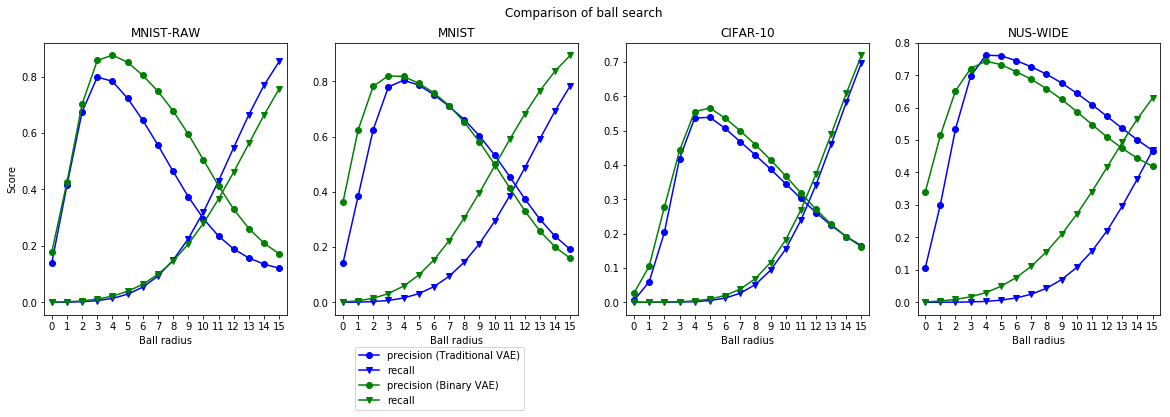

In [151]:
choosed_data = ["MNIST-RAW", "MNIST", "CIFAR-10", "NUS-WIDE"]
f, axx = plt.subplots(1, len(choosed_data), figsize=(20,5), sharey=False)

b_aux = 16
for z in range(len(choosed_data)):
    dat = choosed_data[z].lower()

    axx[z].plot(ball_radius[:b_aux],traditional_dat_BS[dat]["p"][:b_aux],'bo-',label="precision (Traditional VAE)")
    axx[z].plot(ball_radius[:b_aux],traditional_dat_BS[dat]["r"][:b_aux],'bv-', label='recall' ) 
    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["p"][:b_aux],'go-',label="precision (Binary VAE)")
    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["r"][:b_aux],'gv-', label='recall' ) 
    axx[z].set_title(choosed_data[z])
    axx[z].set_xticks(ball_radius)
    axx[z].set_xlabel("Ball radius")
    axx[z].set_xlim(-0.5, len(ball_radius[:b_aux])-.5)
    #axx[z].set_ylim(-0.05)
    
    if z == 0:
        axx[z].set_ylabel("Score")
        axx[z].legend(bbox_to_anchor=(2, -0.1))
        
f.suptitle("Comparison of ball search")
plt.show()